# Test 2: Finetuned Models (DistilBERT & RoBERTa)

This notebook tests if finetuned transformer models have **bias towards resume writing style**:
- Do overstated resumes get higher seniority predictions?
- Do understated resumes get lower seniority predictions?
- Which words influence the model's decisions?

**Models tested:** DistilBERT, RoBERTa (run in parallel)

In [17]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Load test data
df = pd.read_csv("../Test 2 Data/test2_resumes.csv")
print(f"Loaded {len(df)} resume sets (each has neutral, overstated, understated versions)")
print(f"Seniority distribution: {df['seniority'].value_counts().to_dict()}")

Loaded 120 resume sets (each has neutral, overstated, understated versions)
Seniority distribution: {'junior': 40, 'mid': 40, 'senior': 40}


In [19]:
# Load both models
MODEL_PATHS = {
    'distilbert': '../Smaller Models/distilbert_resume_level',
    'roberta': '../Smaller Models/roberta_resume_level'
}

models = {}
tokenizers = {}

for name, path in MODEL_PATHS.items():
    print(f"Loading {name}...", end=" ")
    tokenizers[name] = AutoTokenizer.from_pretrained(path)
    models[name] = AutoModelForSequenceClassification.from_pretrained(path).to(device)
    models[name].eval()
    print("Done")

# Label mapping
id2label = {0: 'junior', 1: 'mid', 2: 'senior'}

Loading distilbert... Done
Loading roberta... Done


In [20]:
def predict(model_name, text):
    """Get prediction from a model."""
    tokenizer = tokenizers[model_name]
    model = models[model_name]
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        pred_id = torch.argmax(outputs.logits, dim=1).item()
    
    return id2label[pred_id]

## Run Predictions (Parallel)

Run both models on all resume versions in parallel.

In [21]:
# Run predictions for all resumes and all styles
results = []

styles = ['neutral', 'overstated', 'understated']
model_names = list(models.keys())

total = len(df) * len(styles) * len(model_names)
count = 0

for idx, row in df.iterrows():
    true_seniority = row['seniority']
    
    for style in styles:
        resume_text = str(row[style])
        
        for model_name in model_names:
            pred = predict(model_name, resume_text)
            
            results.append({
                'idx': idx,
                'true_seniority': true_seniority,
                'style': style,
                'model': model_name,
                'prediction': pred,
                'correct': pred == true_seniority,
                'resume_text': resume_text
            })
            
            count += 1
    
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{len(df)} resumes ({count}/{total} predictions)")

results_df = pd.DataFrame(results)
print(f"\nTotal predictions: {len(results_df)}")

Processed 20/120 resumes (120/720 predictions)
Processed 40/120 resumes (240/720 predictions)
Processed 60/120 resumes (360/720 predictions)
Processed 80/120 resumes (480/720 predictions)
Processed 100/120 resumes (600/720 predictions)
Processed 120/120 resumes (720/720 predictions)

Total predictions: 720


In [22]:
# Save results for later analysis
results_df.to_csv("finetuned_predictions.csv", index=False)
print("Saved to finetuned_predictions.csv")

Saved to finetuned_predictions.csv


---
## Analysis 1: Accuracy by Style

**What it is:** We measure how often the model predicts the correct seniority level for each resume style (neutral, overstated, understated).

**Why we do it:** If accuracy drops significantly for overstated resumes, it means the inflated language confuses the model. If accuracy is similar across styles, the model focuses on actual experience, not writing style.

**How to read the results:**
- **Higher accuracy = better.** The model correctly identifies the true seniority.
- **If overstated accuracy < neutral accuracy:** The power words are misleading the model.
- **If understated accuracy < neutral accuracy:** The humble words are making real experience look less impressive.

In [23]:
print("=" * 70)
print("ACCURACY BY STYLE AND MODEL")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 40)
    model_df = results_df[results_df['model'] == model_name]
    
    for style in ['neutral', 'overstated', 'understated']:
        style_df = model_df[model_df['style'] == style]
        acc = style_df['correct'].mean()
        print(f"  {style:<15}: {acc:.1%}")

ACCURACY BY STYLE AND MODEL

DISTILBERT
----------------------------------------
  neutral        : 44.2%
  overstated     : 33.3%
  understated    : 45.0%

ROBERTA
----------------------------------------
  neutral        : 35.8%
  overstated     : 33.3%
  understated    : 49.2%


---
## Analysis 2: Style Bias Detection

**What it is:** We calculate a "rank difference" for each prediction. We assign numbers: junior=0, mid=1, senior=2. Then: `rank_diff = predicted_rank - true_rank`.

**Why we do it:** This tells us if the model systematically over- or under-estimates seniority based on writing style.

**How to read the results:**
- **Avg Rank Diff = 0:** Model is unbiased (predictions match reality on average)
- **Avg Rank Diff > 0 (positive):** Model OVERESTIMATES seniority (e.g., predicts senior when they're actually mid)
- **Avg Rank Diff < 0 (negative):** Model UNDERESTIMATES seniority (e.g., predicts junior when they're actually senior)
- **Overestimates count:** How many resumes got a higher prediction than their true level
- **Underestimates count:** How many resumes got a lower prediction than their true level

**Key insight:** If overstated resumes have higher rank_diff than neutral, the model has **overstated bias** - it rewards confident language with higher seniority predictions.

In [24]:
# Map seniority to numeric for comparison
seniority_rank = {'junior': 0, 'mid': 1, 'senior': 2}
results_df['true_rank'] = results_df['true_seniority'].map(seniority_rank)
results_df['pred_rank'] = results_df['prediction'].map(seniority_rank)
results_df['rank_diff'] = results_df['pred_rank'] - results_df['true_rank']  # +ve = overestimate

print("=" * 70)
print("PREDICTION BIAS BY STYLE (rank_diff: +ve = overestimate, -ve = underestimate)")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = results_df[results_df['model'] == model_name]
    
    print(f"{'Style':<15} {'Avg Rank Diff':<18} {'Overestimates':<15} {'Underestimates'}")
    for style in ['overstated', 'neutral', 'understated']:
        style_df = model_df[model_df['style'] == style]
        avg_diff = style_df['rank_diff'].mean()
        over = (style_df['rank_diff'] > 0).sum()
        under = (style_df['rank_diff'] < 0).sum()
        print(f"{style:<15} {avg_diff:+.3f}{'':>12} {over:<15} {under}")

PREDICTION BIAS BY STYLE (rank_diff: +ve = overestimate, -ve = underestimate)

DISTILBERT
--------------------------------------------------
Style           Avg Rank Diff      Overestimates   Underestimates
overstated      +0.917             80              0
neutral         +0.583             67              0
understated     +0.550             64              2

ROBERTA
--------------------------------------------------
Style           Avg Rank Diff      Overestimates   Underestimates
overstated      +0.925             80              0
neutral         +0.733             77              0
understated     -0.433             9               52


In [25]:
print("=" * 70)
print("BIAS CHECK: Do overstated resumes get 'promoted'?")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = results_df[results_df['model'] == model_name]
    
    # Check: Junior resumes predicted as senior
    for true_level in ['junior', 'mid']:
        for style in ['overstated', 'neutral', 'understated']:
            subset = model_df[(model_df['true_seniority'] == true_level) & (model_df['style'] == style)]
            senior_preds = (subset['prediction'] == 'senior').sum()
            total = len(subset)
            pct = senior_preds / total * 100 if total > 0 else 0
            print(f"  {true_level.upper()} + {style:<12} → predicted SENIOR: {senior_preds}/{total} ({pct:.1f}%)")
        print()

BIAS CHECK: Do overstated resumes get 'promoted'?

DISTILBERT
--------------------------------------------------
  JUNIOR + overstated   → predicted SENIOR: 30/40 (75.0%)
  JUNIOR + neutral      → predicted SENIOR: 3/40 (7.5%)
  JUNIOR + understated  → predicted SENIOR: 4/40 (10.0%)

  MID + overstated   → predicted SENIOR: 40/40 (100.0%)
  MID + neutral      → predicted SENIOR: 39/40 (97.5%)
  MID + understated  → predicted SENIOR: 28/40 (70.0%)


ROBERTA
--------------------------------------------------
  JUNIOR + overstated   → predicted SENIOR: 31/40 (77.5%)
  JUNIOR + neutral      → predicted SENIOR: 11/40 (27.5%)
  JUNIOR + understated  → predicted SENIOR: 0/40 (0.0%)

  MID + overstated   → predicted SENIOR: 40/40 (100.0%)
  MID + neutral      → predicted SENIOR: 40/40 (100.0%)
  MID + understated  → predicted SENIOR: 2/40 (5.0%)



---
## Analysis 3: Same Person, Different Predictions?

**What it is:** For each person, we check if their 3 resume versions (neutral, overstated, understated) all get the same prediction, or if different styles lead to different predictions.

**Why we do it:** This is the most direct test of style bias. The same person with the same experience should get the same seniority prediction regardless of how they write their resume. If predictions differ, the model is being influenced by writing style, not actual qualifications.

**How to read the results:**
- **Inconsistent predictions = X%:** This percentage of people got DIFFERENT predictions for their 3 resume versions
- **0% inconsistent = perfect.** The model ignores writing style completely.
- **High inconsistent % = biased.** The model changes its mind based on how the resume is written.

**Sample table shows:** For each inconsistent case, what was the true seniority, and what did the model predict for neutral/overstated/understated versions.

In [26]:
print("=" * 70)
print("PREDICTION CONSISTENCY: Same person, different styles")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = results_df[results_df['model'] == model_name]
    
    inconsistent = 0
    style_changes = []
    
    for idx in df.index:
        person_preds = model_df[model_df['idx'] == idx].set_index('style')['prediction']
        
        if len(set(person_preds)) > 1:  # Different predictions for same person
            inconsistent += 1
            style_changes.append({
                'idx': idx,
                'true': df.loc[idx, 'seniority'],
                'neutral': person_preds.get('neutral', '?'),
                'overstated': person_preds.get('overstated', '?'),
                'understated': person_preds.get('understated', '?')
            })
    
    print(f"Resumes with INCONSISTENT predictions across styles: {inconsistent}/{len(df)} ({inconsistent/len(df)*100:.1f}%)")
    
    if style_changes:
        changes_df = pd.DataFrame(style_changes[:10])  # Show first 10
        print("\nSample inconsistent predictions:")
        print(changes_df.to_string(index=False))

PREDICTION CONSISTENCY: Same person, different styles

DISTILBERT
--------------------------------------------------
Resumes with INCONSISTENT predictions across styles: 49/120 (40.8%)

Sample inconsistent predictions:
 idx   true neutral overstated understated
   0 junior     mid     senior      junior
   1 junior  senior        mid      senior
   2 junior  junior     senior         mid
   3 junior     mid     senior      senior
   5 junior     mid     senior         mid
   6 junior     mid     senior         mid
   7 junior     mid     senior      junior
   8 junior  junior        mid         mid
   9 junior  junior     senior         mid
  10 junior  junior        mid         mid

ROBERTA
--------------------------------------------------
Resumes with INCONSISTENT predictions across styles: 112/120 (93.3%)

Sample inconsistent predictions:
 idx   true neutral overstated understated
   0 junior     mid     senior      junior
   2 junior  senior     senior         mid
   3 junior  sen

---
## Analysis 4: Word Influence Analysis

**What it is:** We count how many "power words" (strategic, spearheaded, architected) and "humble words" (assisted, helped, participated) appear in resumes that got each prediction level.

**Why we do it:** This reveals WHAT the model is responding to. If resumes predicted as "senior" have way more power words, the model may be fooled by confident language rather than actual experience.

**How to read the results:**
- **Avg Power Words by Prediction:** If "senior" predictions have ~20 power words but "junior" predictions have ~5, the model associates power words with seniority.
- **Avg Humble Words by Prediction:** If "junior" predictions have more humble words, the model associates modest language with lower seniority.

**Ideal result:** Power/humble word counts should be similar across prediction levels if the model focuses on actual experience. Large differences indicate the model is influenced by word choice.

In [27]:
# Power words and humble words from our validation metric
POWER_WORDS = {
    'spearheaded', 'revolutionized', 'pioneered', 'orchestrated', 'architected',
    'transformed', 'drove', 'championed', 'accelerated', 'maximized',
    'optimized', 'elevated', 'propelled', 'commanded', 'masterminded',
    'dramatically', 'significantly', 'substantially', 'exponentially', 'exceptionally',
    'outstanding', 'exceptional', 'remarkable', 'extraordinary', 'tremendous',
    'critical', 'crucial', 'vital', 'strategic', 'innovative',
    'enterprise', 'comprehensive', 'extensive', 'robust', 'cutting-edge',
    'visionary', 'influential', 'instrumental', 'pivotal', 'key'
}

HUMBLE_WORDS = {
    'helped', 'assisted', 'supported', 'contributed', 'participated',
    'aided', 'collaborated', 'worked', 'involved', 'engaged',
    'some', 'basic', 'minor', 'small', 'routine', 'standard', 'general',
    'occasional', 'limited', 'partial', 'modest', 'simple',
    'team', 'alongside', 'together', 'group', 'collective',
    'somewhat', 'relatively', 'fairly', 'adequately', 'sufficiently'
}

def count_words(text, word_set):
    words = re.findall(r'\b[a-z]+\b', str(text).lower())
    return sum(1 for w in words if w in word_set)

In [28]:
print("=" * 70)
print("WORD INFLUENCE: Power/Humble words in predictions")
print("=" * 70)

results_df['power_count'] = results_df['resume_text'].apply(lambda x: count_words(x, POWER_WORDS))
results_df['humble_count'] = results_df['resume_text'].apply(lambda x: count_words(x, HUMBLE_WORDS))

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    model_df = results_df[results_df['model'] == model_name]
    
    print(f"{'Prediction':<12} {'Avg Power Words':<18} {'Avg Humble Words'}")
    for pred in ['senior', 'mid', 'junior']:
        pred_df = model_df[model_df['prediction'] == pred]
        avg_power = pred_df['power_count'].mean()
        avg_humble = pred_df['humble_count'].mean()
        print(f"{pred:<12} {avg_power:.1f}{'':>14} {avg_humble:.1f}")

WORD INFLUENCE: Power/Humble words in predictions

DISTILBERT
--------------------------------------------------
Prediction   Avg Power Words    Avg Humble Words
senior       11.0               7.5
mid          3.1               9.2
junior       0.8               8.7

ROBERTA
--------------------------------------------------
Prediction   Avg Power Words    Avg Humble Words
senior       13.9               5.4
mid          2.7               11.2
junior       0.3               11.7


In [29]:
# Detailed word analysis: which specific words appear in senior predictions
def get_word_freq(texts, word_set):
    counts = Counter()
    for text in texts:
        words = re.findall(r'\b[a-z]+\b', str(text).lower())
        for w in words:
            if w in word_set:
                counts[w] += 1
    return counts

print("=" * 70)
print("TOP POWER WORDS IN SENIOR PREDICTIONS vs JUNIOR PREDICTIONS")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    model_df = results_df[results_df['model'] == model_name]
    
    senior_texts = model_df[model_df['prediction'] == 'senior']['resume_text']
    junior_texts = model_df[model_df['prediction'] == 'junior']['resume_text']
    
    senior_words = get_word_freq(senior_texts, POWER_WORDS)
    junior_words = get_word_freq(junior_texts, POWER_WORDS)
    
    print("Power words in SENIOR predictions:", dict(senior_words.most_common(5)))
    print("Power words in JUNIOR predictions:", dict(junior_words.most_common(5)))

TOP POWER WORDS IN SENIOR PREDICTIONS vs JUNIOR PREDICTIONS

DISTILBERT
------------------------------------------------------------
Power words in SENIOR predictions: {'strategic': 382, 'comprehensive': 309, 'critical': 248, 'key': 247, 'robust': 141}
Power words in JUNIOR predictions: {'key': 11, 'strategic': 1}

ROBERTA
------------------------------------------------------------
Power words in SENIOR predictions: {'strategic': 379, 'comprehensive': 309, 'critical': 250, 'key': 246, 'robust': 144}
Power words in JUNIOR predictions: {'key': 16, 'strategic': 2}


---
## Analysis 5: Misclassification Deep Dive

**What it is:** We look specifically at the worst mistakes:
- **Juniors predicted as Senior:** People with little experience who got labeled as highly experienced
- **Seniors predicted as Junior:** People with lots of experience who got labeled as beginners

**Why we do it:** These extreme errors are the most unfair. If a junior gets hired as a senior because they overstated their resume, or a senior gets rejected because they wrote modestly, that's a serious problem.

**How to read the results:**
- **Style breakdown:** Which writing style caused the misclassification? If most "juniors predicted as senior" are overstated resumes, the model is being fooled by confident language.
- **Avg power/humble words:** Did these misclassified resumes have unusually high power words or humble words?

**What we're looking for:**
- If overstated juniors get predicted as senior → **overstated bias confirmed**
- If understated seniors get predicted as junior → **understated bias confirmed**

In [30]:
print("=" * 70)
print("MISCLASSIFICATION ANALYSIS")
print("=" * 70)

for model_name in model_names:
    print(f"\n{model_name.upper()}")
    print("-" * 60)
    model_df = results_df[results_df['model'] == model_name]
    
    # Juniors predicted as Senior (overpromoted)
    overpromoted = model_df[(model_df['true_seniority'] == 'junior') & (model_df['prediction'] == 'senior')]
    print(f"\nJuniors predicted as SENIOR: {len(overpromoted)}")
    if len(overpromoted) > 0:
        print(f"  Style breakdown: {overpromoted['style'].value_counts().to_dict()}")
        print(f"  Avg power words: {overpromoted['power_count'].mean():.1f}")
        print(f"  Avg humble words: {overpromoted['humble_count'].mean():.1f}")
    
    # Seniors predicted as Junior (underpromoted)
    underpromoted = model_df[(model_df['true_seniority'] == 'senior') & (model_df['prediction'] == 'junior')]
    print(f"\nSeniors predicted as JUNIOR: {len(underpromoted)}")
    if len(underpromoted) > 0:
        print(f"  Style breakdown: {underpromoted['style'].value_counts().to_dict()}")
        print(f"  Avg power words: {underpromoted['power_count'].mean():.1f}")
        print(f"  Avg humble words: {underpromoted['humble_count'].mean():.1f}")

MISCLASSIFICATION ANALYSIS

DISTILBERT
------------------------------------------------------------

Juniors predicted as SENIOR: 37
  Style breakdown: {'overstated': 30, 'understated': 4, 'neutral': 3}
  Avg power words: 17.0
  Avg humble words: 4.4

Seniors predicted as JUNIOR: 0

ROBERTA
------------------------------------------------------------

Juniors predicted as SENIOR: 42
  Style breakdown: {'overstated': 31, 'neutral': 11}
  Avg power words: 15.8
  Avg humble words: 4.5

Seniors predicted as JUNIOR: 9
  Style breakdown: {'understated': 9}
  Avg power words: 0.2
  Avg humble words: 14.4


---
## Summary Visualization

**Left chart (Accuracy):** Higher bars = better. Shows how well each model predicts correctly for each style.

**Right chart (Bias):** Bars at 0 = unbiased. Positive bars = model overestimates seniority. Negative bars = model underestimates seniority.

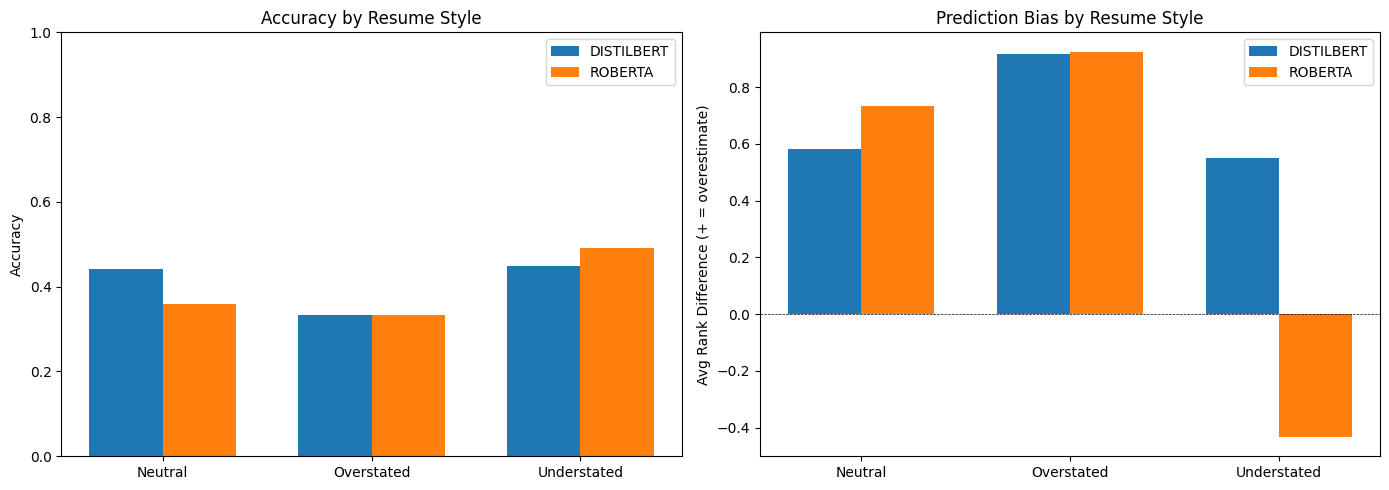

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by style for each model
styles = ['neutral', 'overstated', 'understated']
x = np.arange(len(styles))
width = 0.35

for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    accs = [model_df[model_df['style'] == s]['correct'].mean() for s in styles]
    axes[0].bar(x + i*width, accs, width, label=model_name.upper())

axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy by Resume Style')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(['Neutral', 'Overstated', 'Understated'])
axes[0].legend()
axes[0].set_ylim(0, 1)

# Plot 2: Average rank difference (bias) by style
for i, model_name in enumerate(model_names):
    model_df = results_df[results_df['model'] == model_name]
    diffs = [model_df[model_df['style'] == s]['rank_diff'].mean() for s in styles]
    axes[1].bar(x + i*width, diffs, width, label=model_name.upper())

axes[1].set_ylabel('Avg Rank Difference (+ = overestimate)')
axes[1].set_title('Prediction Bias by Resume Style')
axes[1].set_xticks(x + width/2)
axes[1].set_xticklabels(['Neutral', 'Overstated', 'Understated'])
axes[1].legend()
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

---
## Findings Summary

**How to interpret the final numbers:**

- **Accuracy:** Percentage of correct predictions. Higher = better.
- **Bias (+ or -):** 
  - `+0.5` means on average the model predicts half a level too high (e.g., predicting mid as senior)
  - `-0.5` means on average the model predicts half a level too low
  - `0` is perfect - no systematic bias
- **Inconsistent predictions:** Percentage of people who got different predictions for their 3 resume styles. Lower = better. High % means the model is easily fooled by writing style.

In [32]:
print("=" * 70)
print("FINAL SUMMARY")
print("=" * 70)

for model_name in model_names:
    model_df = results_df[results_df['model'] == model_name]
    
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    
    # Overall accuracy
    neutral_acc = model_df[model_df['style'] == 'neutral']['correct'].mean()
    over_acc = model_df[model_df['style'] == 'overstated']['correct'].mean()
    under_acc = model_df[model_df['style'] == 'understated']['correct'].mean()
    
    print(f"Neutral accuracy:     {neutral_acc:.1%}")
    print(f"Overstated accuracy:  {over_acc:.1%}")
    print(f"Understated accuracy: {under_acc:.1%}")
    
    # Bias
    over_bias = model_df[model_df['style'] == 'overstated']['rank_diff'].mean()
    under_bias = model_df[model_df['style'] == 'understated']['rank_diff'].mean()
    
    print(f"\nOverstated bias:  {over_bias:+.3f} ({'tends to overestimate' if over_bias > 0 else 'tends to underestimate'})")
    print(f"Understated bias: {under_bias:+.3f} ({'tends to overestimate' if under_bias > 0 else 'tends to underestimate'})")
    
    # Inconsistency
    inconsistent = 0
    for idx in df.index:
        preds = model_df[model_df['idx'] == idx]['prediction'].unique()
        if len(preds) > 1:
            inconsistent += 1
    print(f"\nInconsistent predictions: {inconsistent}/{len(df)} ({inconsistent/len(df)*100:.1f}%)")

FINAL SUMMARY

DISTILBERT
--------------------------------------------------
Neutral accuracy:     44.2%
Overstated accuracy:  33.3%
Understated accuracy: 45.0%

Overstated bias:  +0.917 (tends to overestimate)
Understated bias: +0.550 (tends to overestimate)

Inconsistent predictions: 49/120 (40.8%)

ROBERTA
--------------------------------------------------
Neutral accuracy:     35.8%
Overstated accuracy:  33.3%
Understated accuracy: 49.2%

Overstated bias:  +0.925 (tends to overestimate)
Understated bias: -0.433 (tends to underestimate)

Inconsistent predictions: 112/120 (93.3%)
